In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import dill as pickle
import random
from shutil import copyfile
import sys
import copy
import numpy as np
import math
from einops import rearrange
np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = '/Users/samsonkoelle/manifoldflasso_jmlr'
sys.path.append(workingdirectory)
os.chdir(workingdirectory)



def dup_cols(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[:,[indx]],axis=1)

from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multirun import get_cosines
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch_customcolors
from codes.otherfunctions.multirun import get_grads_noshape_swiss
from codes.otherfunctions.multiplot import plot_betas_customcolors2
from codes.flasso.Replicate import Replicate
from codes.experimentclasses.SwissRoll49_2 import SwissRoll49
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.flasso.GradientGroupLasso import get_sr_lambda_sam_parallel

from megaman.geometry import RiemannMetric
from megaman.embedding import LTSA
from megaman.embedding import Isomap



/Users/samsonkoelle/manifoldflasso_jmlr


In [2]:

#set parameters
n = 5000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-14 #convergence criteria for lasso
n_neighbors = 1000 #number of neighbors in megaman
n_components = 2 #number of embedding dimensions (diffusion maps)
diffusion_time = 1.
nreps = 2
m = 2
dimnoise = 2
dim = 2 #manifold dimension
cores = 16 #number of cores for parallel processing
p = 51
lambda_max = 1
max_search = 30

folder = workingdirectory + '/Figures/swissroll/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)

savename = 'swissroll_041420_5k'
savefolder = 'swissroll'

experiment = SwissRoll49(xvar = 0.0,cores = cores, noise = False)
experiment.M = experiment.generate_data(n=n,theta=np.pi / 4)  # if noise == False then noise parameters are overriden
experiment.q = n_components
experiment.M.geom = experiment.M.compute_geom(diffusion_time, n_neighbors)
print('preembed', datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S"))
experiment.N = experiment.M.get_embedding3(experiment.M.geom, n_components, diffusion_time, dim)


preembed May_07_2021_15_00_37


In [3]:
experiment.M.geom.affinity_matrix[0].data

array([1.00000000e+00, 8.38806339e-01, 5.81629809e-01, 3.63026016e-01,
       6.90721942e-04, 8.13292584e-03, 4.93709158e-04, 1.83604428e-02,
       1.93536727e-03, 1.76089924e-04, 5.22006165e-02, 1.79448144e-03,
       1.23740107e-03, 2.94500906e-01, 7.21951119e-04, 3.24457177e-04,
       1.39484408e-03, 4.25213599e-04, 1.89842861e-04, 2.38595070e-02,
       1.58035639e-03, 8.34225587e-03, 2.05151226e-03, 8.12279013e-03,
       5.25887560e-03, 6.16617605e-03, 2.15223424e-01, 2.09989639e-04,
       7.89110967e-02, 3.03183220e-03, 3.73667298e-01, 1.28933088e-04,
       2.95701131e-04, 1.92035870e-03, 9.91241191e-02, 2.39413755e-01,
       6.22620328e-02, 1.64172520e-02, 5.66387537e-01, 2.52243933e-03,
       1.54796728e-01, 9.73680210e-04, 8.07441960e-01, 3.07891263e-04,
       2.05997311e-02, 1.14383779e-02, 2.22411070e-02, 1.59081699e-04,
       1.73322870e-02, 2.77864521e-03, 3.80814513e-04, 2.80020581e-02,
       2.17428570e-02, 4.97552688e-02, 2.27394088e-01, 6.22010912e-04,
      

In [4]:
experiment.p = p
experiment.itermax = itermax
experiment.tol = tol
experiment.dimnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.dimnoise = dimnoise
experiment.m = m
#experiment.

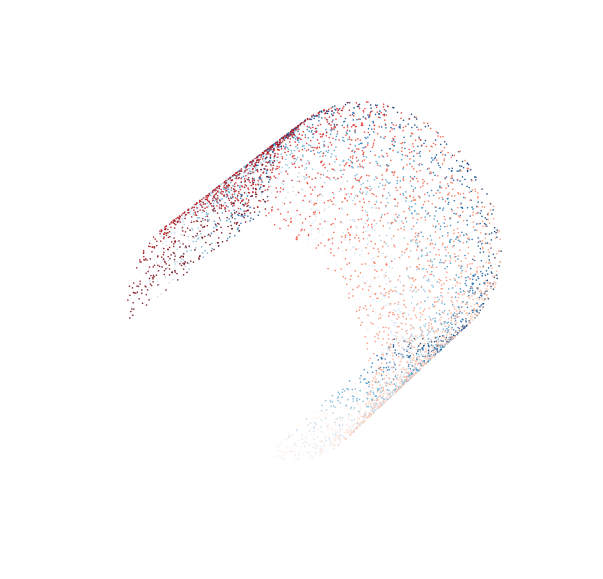

In [5]:
%matplotlib inline
unr = experiment.M.data @ experiment.rotator.transpose()
data = unr[:,:3]

fig, axes_all = plt.subplots(figsize=(10,10))
axes_all.set_axis_off()
alpha = .05
ax = fig.add_subplot(1,1,1, projection='3d')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
s = 1
alpha = 1.
set1  = list(range(2500))
set2 = np.asarray(list(range(2500))) + 2500
ax.scatter(x[set1], y[set1], z[set1], s=s, alpha=alpha, marker='.', c = experiment.ts[set1], cmap = 'Reds')
ax.scatter(x[set2], y[set2], z[set2], s=s, alpha=alpha, marker='.', c = experiment.ys[set2], cmap = 'Blues')
ax.set_axis_off()

In [6]:
N_internal = RiemannianManifold(np.asarray([experiment.ts ,experiment.ys]).transpose(),2)
d = dim
geom = experiment.M.geom
geom.rmetric = RiemannMetric(N_internal.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom.rmetric.get_rmetric()
N_internal.geom = geom
#df_M,dg_M,dg_x ,dgx_norm  = get_grads_noshape_swiss(experiment, experiment.M, N2, selected_points)



In [7]:
swiss_internal = np.asarray([experiment.ts ,experiment.ys]).transpose()
#N_internal.geom = experiment.M.geom

print('Spectral')
N_spectral = experiment.N
geom_spectral = experiment.M.geom
geom_spectral.rmetric = RiemannMetric(N_spectral.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom_spectral.rmetric.get_rmetric()
N_spectral.geom = geom_spectral

Spectral


In [8]:


#slightly slow
print('LTSA')
n_components = m
ltsa = LTSA(n_components=n_components,eigen_solver='arpack',geom=experiment.M.geom)
embed_ltsa = ltsa.fit_transform(experiment.M.data)
N_ltsa = RiemannianManifold(embed_ltsa,2)
geom_ltsa = experiment.M.geom
geom_ltsa.rmetric = RiemannMetric(N_ltsa.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom_ltsa.rmetric.get_rmetric()
N_ltsa.geom = geom_ltsa

print('Isomap')
isomap = Isomap(n_components=n_components, eigen_solver='arpack',geom=experiment.M.geom)
embed_isomap = isomap.fit_transform(experiment.M.data)
N_isomap = RiemannianManifold(embed_isomap,2)
geom_isomap = experiment.M.geom
geom_isomap.rmetric = RiemannMetric(N_isomap.data,experiment.M.geom.laplacian_matrix,n_dim=d)
geom_isomap.rmetric.get_rmetric()
N_isomap.geom = geom_isomap
swiss_isomap = N_isomap.data

LTSA


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


Isomap


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [9]:
inds1 = np.asarray(list(range(2500)))*2
inds2 = np.asarray(list(range(2500)))*2 + 1

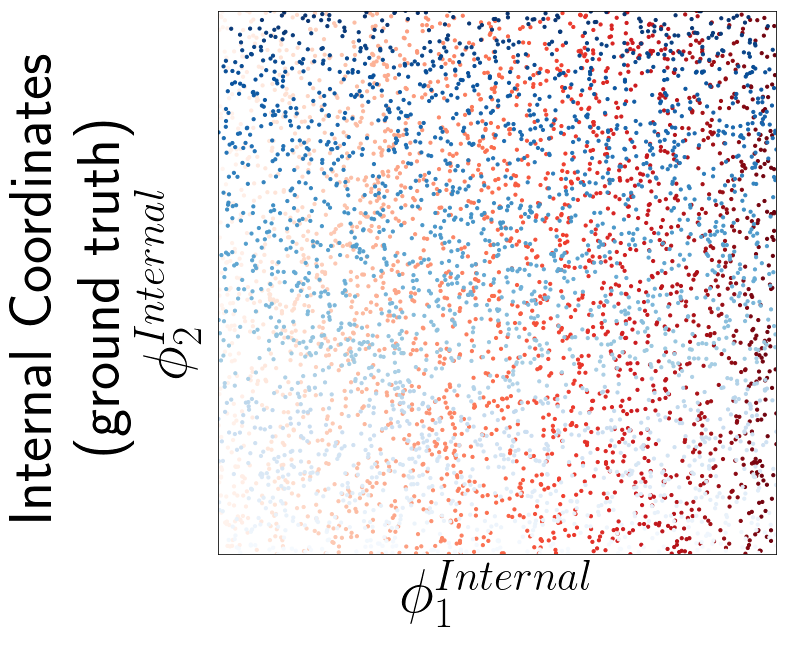

In [83]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )

axes_all.scatter(swiss_internal[inds1,0],swiss_internal[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_internal[inds2,0],swiss_internal[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_internal[:,0].min(), swiss_internal[:,0].max())
axes_all.set_ylim(swiss_internal[:,1].min(), swiss_internal[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[0,0].set_ylabel(r'$\phi_2$')
#axes_all[0,0].set_xlabel(r'$\phi_1$')
axes_all.set_xlabel(r'$\phi_1^{Internal}$', fontsize = 60, labelpad=20)
axes_all.set_ylabel(r'$\phi_2^{Internal}$', fontsize = 60)
fig.text(-0.08, 0.5, 'Internal Coordinates \n (ground truth)', ha='center', va='center', rotation='vertical', fontsize = 60)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal', bbox_inches = "tight")


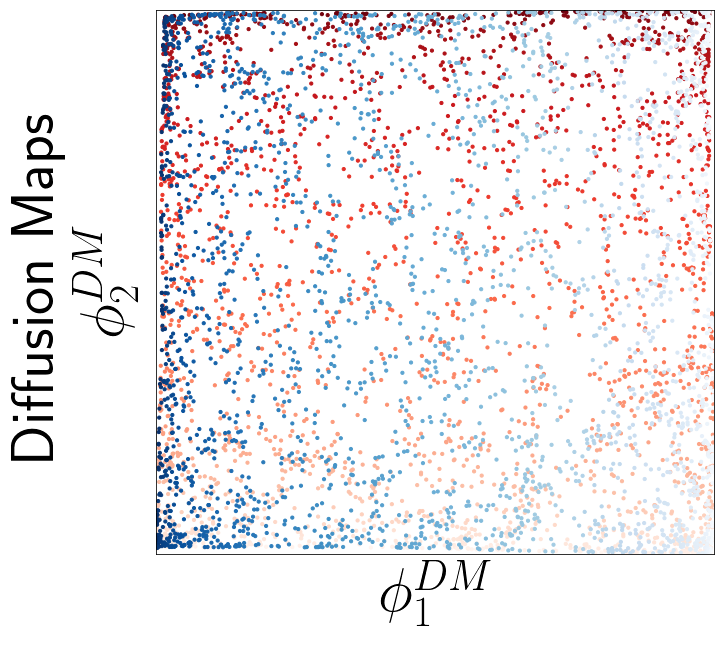

In [82]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )
swiss_spectral = N_spectral.data
axes_all.scatter(swiss_spectral[inds1,0],swiss_spectral[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_spectral[inds2,0],swiss_spectral[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_spectral[:,0].min(), swiss_spectral[:,0].max())
axes_all.set_ylim(swiss_spectral[:,1].min(), swiss_spectral[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[1,0].set_ylabel(r'$\phi_2$')
#axes_all[1,0].set_xlabel(r'$\phi_1$')
axes_all.set_xlabel(r'$\phi_1^{DM}$', fontsize = 60, labelpad=20)
axes_all.set_ylabel(r'$\phi_2^{DM}$', fontsize = 60)
#secax = axes_all[1,0].secondary_yaxis('left')# functions=(deg2rad, rad2deg))
#secax.set_text(x 'Spectral Embedding', labelpad = 20,fontsize = 60)
#axes_all[1,0].set_ylabel(r'$\phi_2$', fontsize = 60, labelpad = 20)
fig.text(-0.04, 0.5, 'Diffusion Maps', ha='center', va='center', rotation='vertical', fontsize = 60)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_spectral', bbox_inches = "tight")


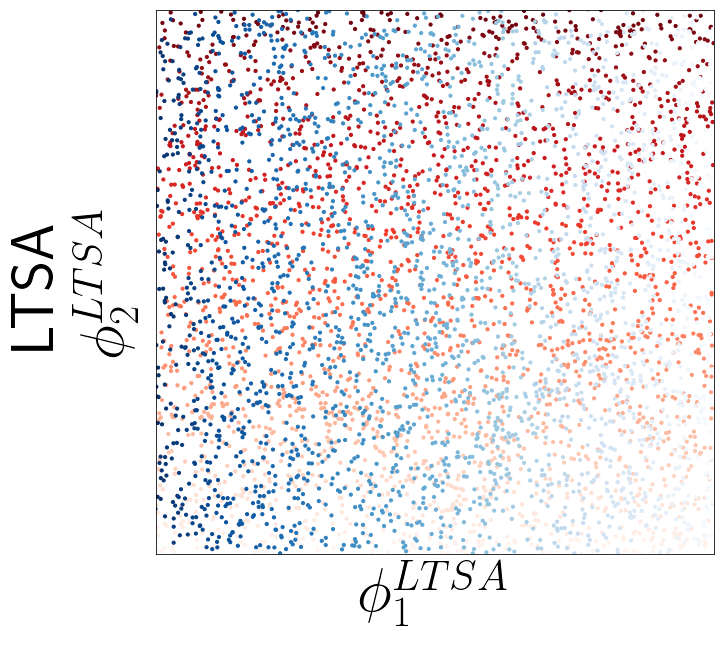

In [84]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )
swiss_ltsa = N_ltsa.data
axes_all.scatter(swiss_ltsa[inds1,0],swiss_ltsa[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_ltsa[inds2,0],swiss_ltsa[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_ltsa[:,0].min(), swiss_ltsa[:,0].max())
axes_all.set_ylim(swiss_ltsa[:,1].min(), swiss_ltsa[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[3,0].set_ylabel(r'$\phi_2$')
axes_all.set_xlabel(r'$\phi_1^{LTSA}$', fontsize = 60, labelpad=20)
axes_all.set_ylabel(r'$\phi_2^{LTSA}$', fontsize = 60)
fig.text(-0.04, 0.5, 'LTSA', ha='center', va='center', rotation='vertical', fontsize = 60)

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_ltsa', bbox_inches = "tight")

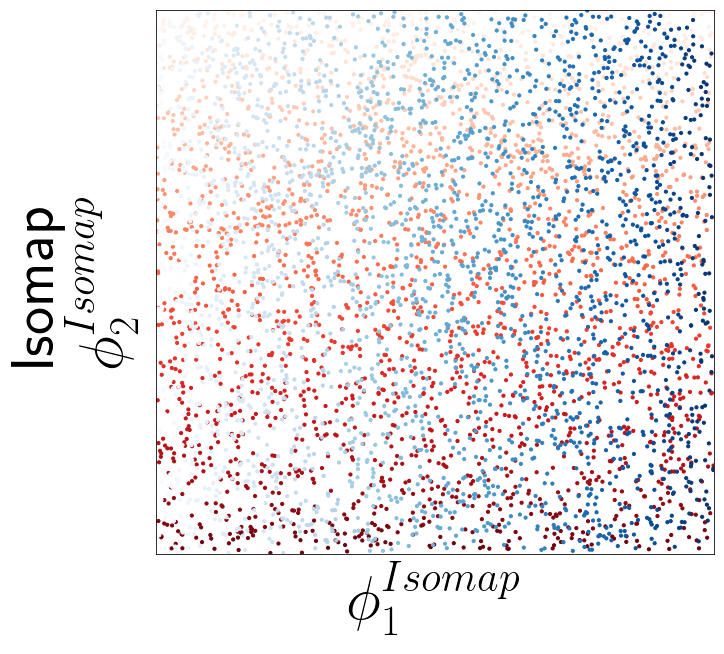

In [85]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )

axes_all.scatter(swiss_isomap[inds1,0],swiss_isomap[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_isomap[inds2,0],swiss_isomap[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_isomap[:,0].min(), swiss_isomap[:,0].max())
axes_all.set_ylim(swiss_isomap[:,1].min(), swiss_isomap[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
#axes_all[2,0].set_ylabel(r'$\phi_2$')
#axes_all[2,0].set_xlabel(r'$\phi_1$')
axes_all.set_xlabel(r'$\phi_1^{Isomap}$', fontsize = 60, labelpad=20)
axes_all.set_ylabel(r'$\phi_2^{Isomap}$', fontsize = 60)
fig.text(-0.04, 0.5, 'Isomap', ha='center', va='center', rotation='vertical', fontsize = 60)
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_isomap', bbox_inches = "tight")


In [14]:
nsel = 100

In [15]:
n = 5000
selected_points_save = np.zeros((nreps,nsel))
replicates = {}
selected_points_save = np.zeros((nreps,nsel), dtype = int)

In [16]:
print('pre-gradient acquisition')
print(datetime.datetime.now())
replicates_internal = {}
replicates_isomap = {}
replicates_spectral = {}
replicates_ltsa = {}
for i in range(nreps):
    print(i)
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates_internal[i] = Replicate(nsel=nsel, n=n, selected_points=selected_points)
    replicates_internal[i].nsel = nsel
    replicates_internal[i].selected_points = selected_points
    replicates_internal[i].df_M,replicates_internal[i].dg_M,replicates_internal[i].dg_x ,replicates_internal[i].dgx_norm   = get_grads_noshape_swiss(experiment, experiment.M,  N_internal, selected_points)
    replicates_internal[i].dg_M = np.swapaxes(replicates_internal[i].dg_M, 1,2)
 
    replicates_isomap[i] = Replicate(nsel=nsel, n=n, selected_points=selected_points)
    replicates_isomap[i].selected_points = selected_points
    replicates_isomap[i].df_M,replicates_isomap[i].dg_M,replicates_isomap[i].dg_x ,replicates_isomap[i].dgx_norm   = get_grads_noshape_swiss(experiment, experiment.M,  N_isomap, selected_points)
    replicates_isomap[i].dg_M = np.swapaxes(replicates_isomap[i].dg_M, 1,2)
    
    replicates_spectral[i] = Replicate(nsel=nsel, n=n, selected_points=selected_points)
    replicates_spectral[i].selected_points = selected_points
    replicates_spectral[i].df_M,replicates_spectral[i].dg_M,replicates_spectral[i].dg_x ,replicates_spectral[i].dgx_norm   = get_grads_noshape_swiss(experiment, experiment.M,  N_spectral, selected_points)
    replicates_spectral[i].dg_M = np.swapaxes(replicates_spectral[i].dg_M, 1,2)
    
    replicates_ltsa[i] = Replicate(nsel=nsel, n=n, selected_points=selected_points)
    replicates_ltsa[i].selected_points = selected_points
    replicates_ltsa[i].df_M,replicates_ltsa[i].dg_M,replicates_ltsa[i].dg_x ,replicates_ltsa[i].dgx_norm   = get_grads_noshape_swiss(experiment, experiment.M,  N_ltsa, selected_points)
    replicates_ltsa[i].dg_M = np.swapaxes(replicates_ltsa[i].dg_M, 1,2)
    



pre-gradient acquisition
2021-04-13 11:53:04.700608
0
1


In [17]:
selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100


print('pre-gradient descent')
print(datetime.datetime.now())
cores = 16
# pcor = Pool(cores)
# results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate), batch_stream(replicates))

results_internal = {}
results_spectral = {}
results_isomap = {}
results_ltsa = {}

ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates_internal[r].df_M , replicates_internal[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
replicates_internal[r].results = get_sr_lambda_sam_parallel(replicates_internal[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)
ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates_spectral[r].df_M , replicates_spectral[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
replicates_spectral[r].results = get_sr_lambda_sam_parallel(replicates_spectral[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)
ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates_ltsa[r].df_M , replicates_ltsa[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
replicates_ltsa[r].results = get_sr_lambda_sam_parallel(replicates_ltsa[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)
ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates_isomap[r].df_M , replicates_isomap[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
replicates_isomap[r].results = get_sr_lambda_sam_parallel(replicates_isomap[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


pre-gradient descent
2021-04-13 11:53:08.967309
initializing lambda search
converged 999.9595859172581
0 499.97979295862905 probe
converged 499.97979295862905
we did it [0 1]
initializing lambda search
converged 1000.2183110699832
0 500.1091555349916 probe
converged 500.1091555349916
we did it [0 1]
initializing lambda search
converged 999.9558244030017
0 499.9779122015008 probe
converged 499.9779122015008
we did it [0 1]
initializing lambda search
converged 999.9520399818995
0 499.97601999094974 probe
converged 499.97601999094974
we did it [0 1]


In [18]:
from codes.otherfunctions.utils import get_min_min, get_mu_full_ind, get_kappa_s,get_gamma_max


nreps = 2
nsel = 100
min_mins = np.zeros(nreps, dtype = np.float64)
mus = np.zeros(nreps, dtype = np.float64)
kappas = np.zeros(nreps, dtype = np.float64)
gamma_maxs = np.zeros(nreps, dtype = np.float64)
n = nsel
for r in range(nreps):
    print(r)
    inds = np.asarray([0,1])#sel_tol[r]
    dg_M = replicates_isomap[r].dg_M
    min_mins[r]  = get_min_min(dg_M[:,:,inds]*n)
    mus[r] = get_mu_full_ind(np.swapaxes(dg_M,1,2)*n, inds)
    kappas[r] = get_kappa_s(replicates_isomap[r].dg_M[:,:,inds[0]:(inds[0]+1)]*n)
    gamma_maxs[r] = get_gamma_max(dg_M[:,:,inds]*np.sqrt(n ) )

    

0
1


In [19]:
import pandas as pd

In [20]:
columns = np.asarray([r'$\bar \mu$', r'$\sigma_\mu$',
                     r'$\bar {\kappa_S}$', r'$\sigma_{\kappa_S}$',
                     r'$\bar {\gamma_{\text{max}}}$', r'$\sigma_{\gamma_{\text{max}}}$',
                     r'$\bar {\min_{i = 1}^{n} \min_{j \in S } ||x_{ij}|| }$', r'$\sigma_\mu$'])

df = pd.DataFrame(np.asarray([np.mean(mus), np.sqrt(np.var(mus)), 
                    np.mean(kappas), np.sqrt(np.var(kappas)),
                    np.mean(gamma_maxs),np.sqrt(np.var(gamma_maxs)),
                    np.mean(min_mins),np.sqrt(np.var(min_mins))]).transpose(), index = columns).transpose()

df.to_csv('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/swissparam.csv')


In [21]:
def get_ordered_results(replicate):
    cs = rearrange(np.asarray(list(replicate.results[1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(replicate.results[1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicate.cs = cs
    replicate.cs_reorder = cs_reorder
    replicate.xaxis_reorder = xaxis_reorder
    replicate.xaxis = xaxis    
    return(replicate)

In [27]:
r = 0
replicates_ltsa[r] = get_ordered_results(replicates_ltsa[r])
replicates_internal[r] = get_ordered_results(replicates_internal[r])
replicates_isomap[r] = get_ordered_results(replicates_isomap[r])
replicates_spectral[r] = get_ordered_results(replicates_spectral[r])

In [28]:
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])

In [69]:
#matplotlib.rc('font', family='sans-serif') 
def plot_reg_path_ax_lambdasearch_customcolors_names(axes, coeffs, xaxis, fig, colors, names):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    # xlabel = r"$\displaystyle \lambda$"
    # ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    # maxes = np.zeros(q)
    # for k in range(q):
    #     maxes[k] = np.linalg.norm(coeffs[:, k, :, :], axis=1).max()
    # normax = maxes.max()
    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for k in range(q):
        for j in range(p):
            toplot = np.linalg.norm(coeffs[:, k, :, j], axis=1)
            w = .15
            widths = np.asarray([width(xaxis[i], w) for i in range(len(xaxis))])
            # axes[k+1].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
            axes[k + 1].plot(xaxis, toplot, 'go--', linewidth=10, markersize=0, alpha=1.,
                             color=colors[j], label=gnames[j])
    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        axes[0].plot(xaxis, toplot, 'go--', linewidth=10, markersize=0, alpha=.5,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    for k in range(1 + q):
        axes[k].tick_params(labelsize=50)
        axes[k].set_xscale('symlog')
        axes[k].set_yscale('symlog')
        axes[k].set_ylim(bottom=0, top=normax)
        # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
        if (k == 0):
            tixx = np.hstack(
                [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
        if k != 0:
            # axes[k].set_yticks(tixx)
            axes[k].set_yticklabels([])
        if k != q:
            axes[k + 1].set_title(names[k], fontsize=40)
            # axes[k + 1].set_title(r"$\phi_{{{}}}$.format(k)")
        if k == 0:
            axes[k].set_title("Combined", fontdict={'fontsize': 50})
    for k in range(1 + q):
        axes[k].grid(True, which="both", alpha=True)
        axes[k].set_xlabel(r"$\lambda$", fontsize=50)
        axes[k].set_xticklabels([])
        axes[k].set_xticks([])

    axes[0].set_ylabel(r"$||\beta_j||$", fontsize=50)




In [70]:
from matplotlib import rcParams

from pylab import rcParams
rcParams['figure.figsize'] = 25, 10

def width(p,w):
    if p > 1.:
        output = 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
    else:
        output = w
    return(output)


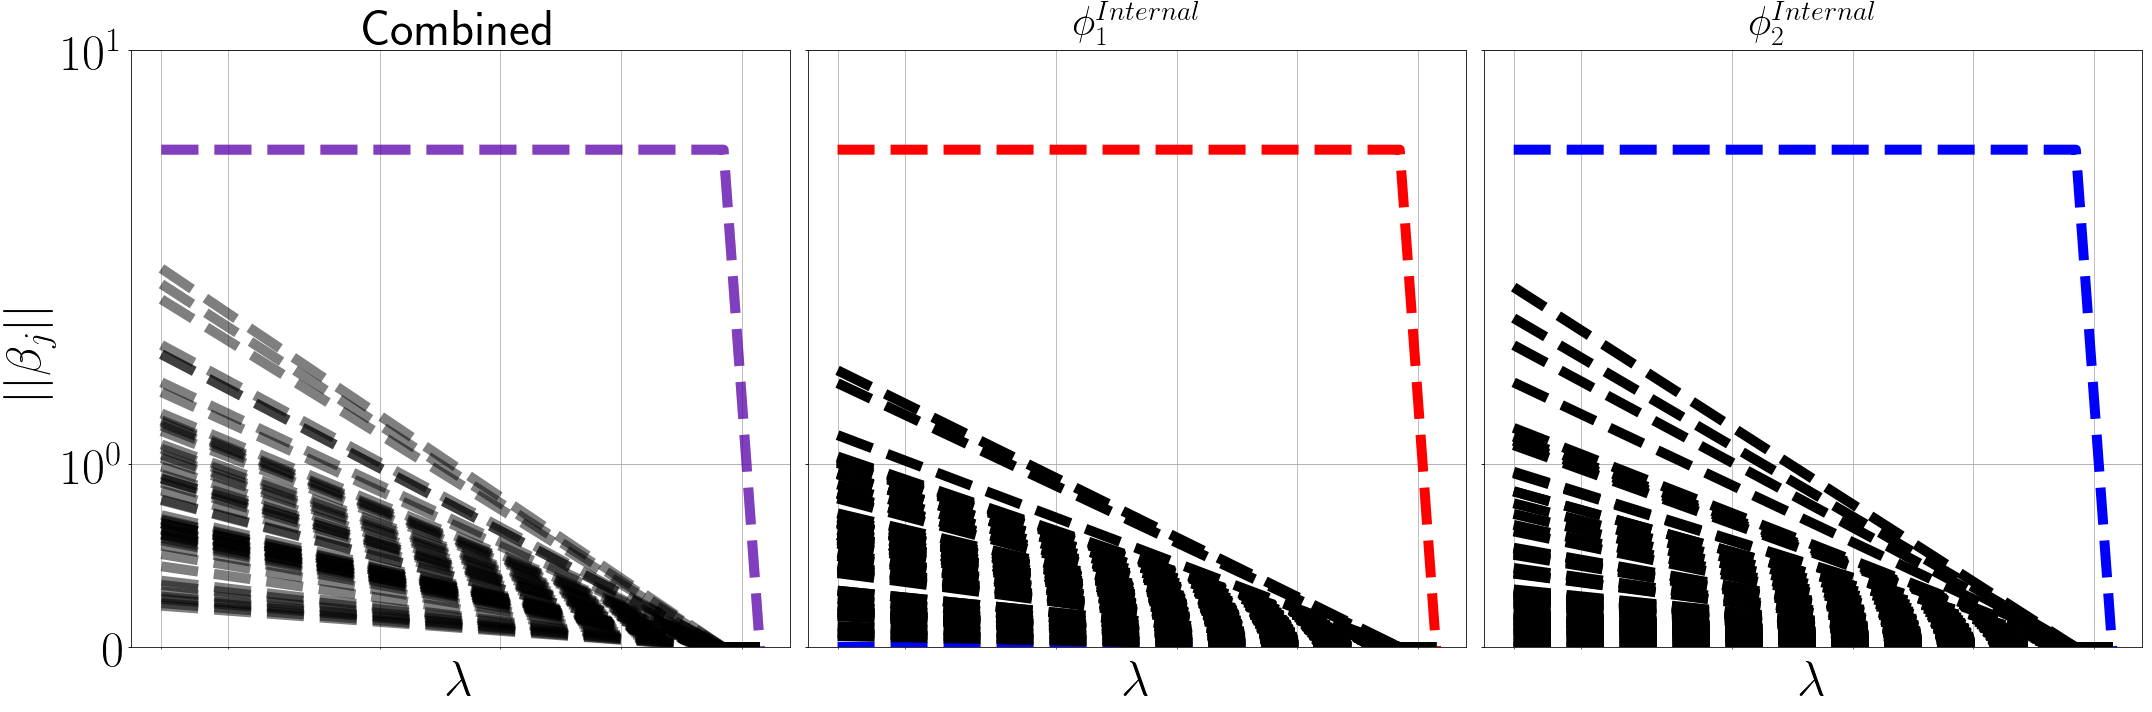

In [71]:
%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Internal}$', r'$\phi_2^{Internal}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates_internal[0].cs_reorder, replicates_internal[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all[2].legend('off')
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")

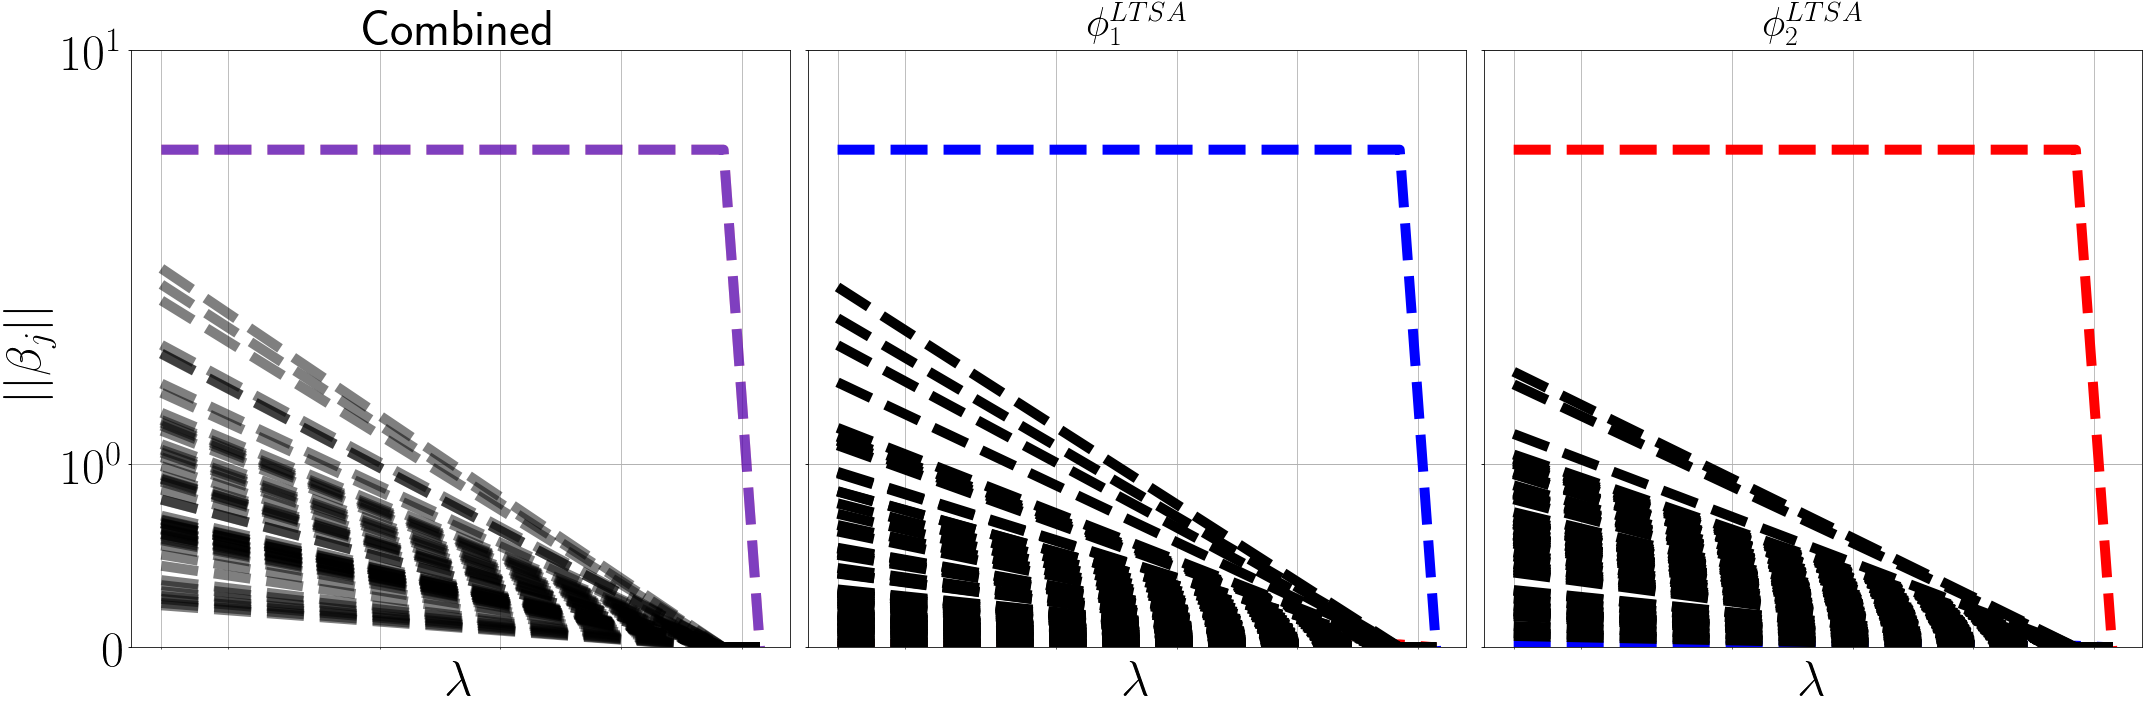

In [72]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

names = [r'$\phi_1^{LTSA}$', r'$\phi_2^{LTSA}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates_ltsa[0].cs_reorder, replicates_ltsa[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors,names)
#axes_all.colorbar('off')
plt.tight_layout()

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_ltsa_mflasso', bbox_inches = "tight")


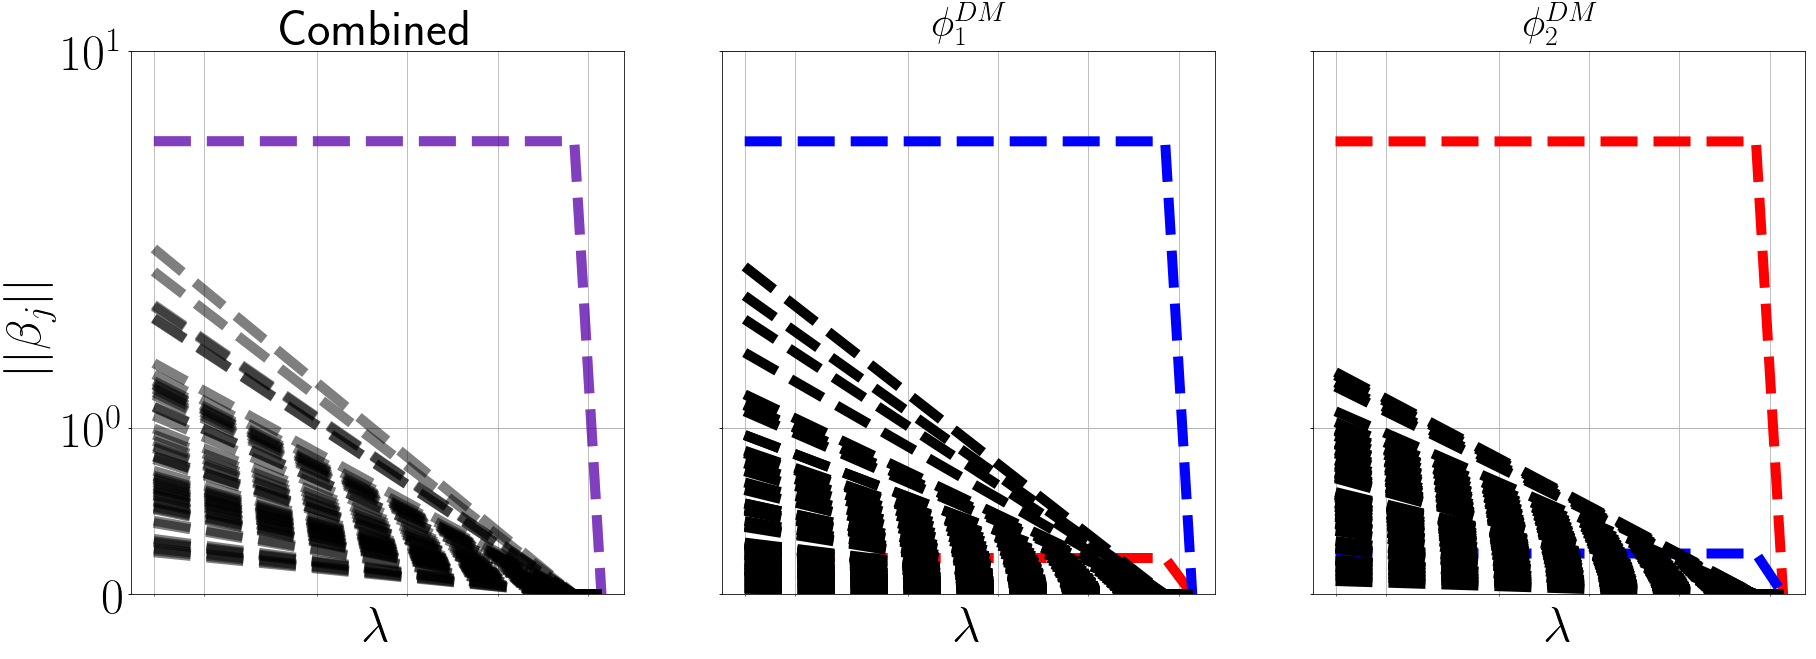

In [73]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

names = [r'$\phi_1^{DM}$', r'$\phi_2^{DM}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates_spectral[0].cs_reorder, replicates_spectral[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors,names)
#axes_all.colorbar('off')
#plt.tight_layout()

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_spectral_mflasso', bbox_inches = "tight")


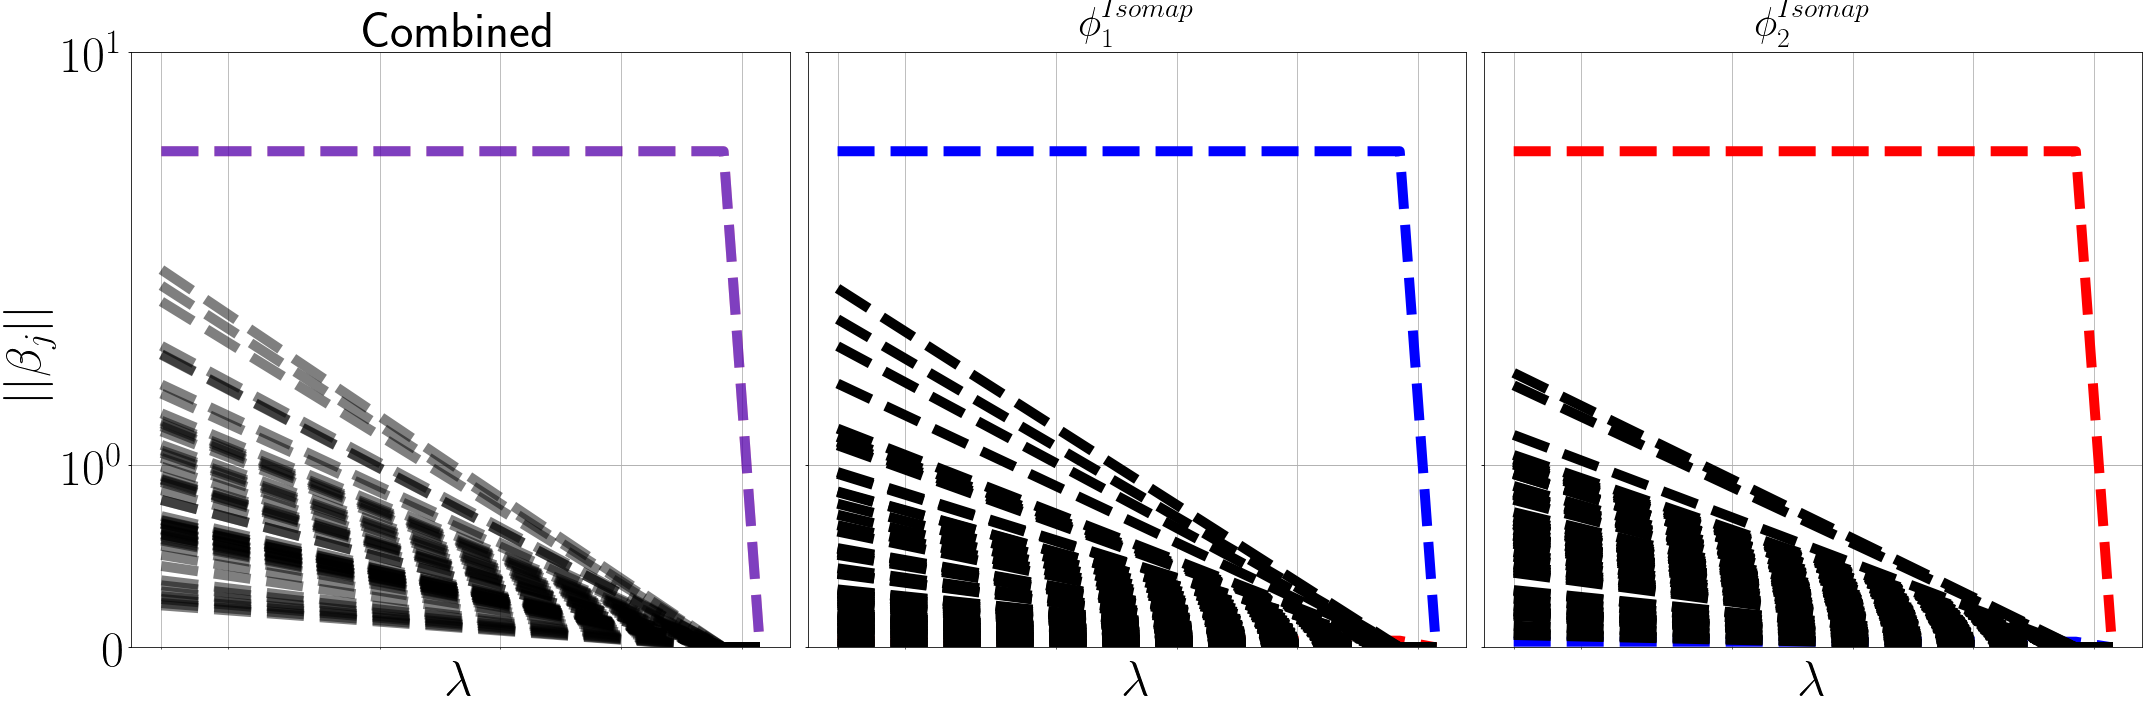

In [74]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Isomap}$', r'$\phi_2^{Isomap}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates_isomap[0].cs_reorder, replicates_isomap[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all.colorbar('off')
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_isomap_mflasso', bbox_inches = "tight")

In [25]:
from codes.otherfunctions.utils import get_min_min, get_mu_full_ind, get_kappa_s,get_gamma_max


In [30]:
nreps = 2
nsel = 100
min_mins = np.zeros(nreps, dtype = np.float64)
mus = np.zeros(nreps, dtype = np.float64)
kappas = np.zeros(nreps, dtype = np.float64)
gamma_maxs = np.zeros(nreps, dtype = np.float64)
n = nsel
for r in range(nreps):
    print(r)
    inds = np.asarray([0,1])#sel_tol[r]
    dg_M = replicates_ltsa[r].dg_M
    min_mins[r]  = get_min_min(dg_M[:,:,inds]*n)
    mus[r] = get_mu_full_ind(np.swapaxes(dg_M,1,2)*n, inds)
    kappas[r] = get_kappa_s(replicates_ltsa[r].dg_M[:,:,inds[0]:(inds[0]+1)]*n)
    gamma_maxs[r] = get_gamma_max(dg_M[:,:,inds]*np.sqrt(n ) )

    

0
1
